# Generative Adversarial Networks(GAN) - PyTorch Tutorial

![image](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FHwq72%2FbtqAY6E0wYb%2FBFRgtJWTY3Ij9BKks7vsM1%2Fimg.png)

This kernel is for those new to gan.

And It was coded with pytorch, and all the code was converted into the familiar Jupyter notebook form for data analysts and machine learning engineers by referring to the gan official Python code.

I hope that many Kaglers will be interested in Generative Adversarial Networks(GAN), and that it will be shared and helpful to more people. So let's get started!

## MAIN Reference
1. [PyTorch-GAN | Github/eriklindernoren | Collection of PyTorch implementations of GAN](https://github.com/sw-song/PyTorch-GAN)


## Index
```
Step 1. Import Libraries
Step 2. Initial Setting
Step 3. Define Generator
Step 4. Define Discriminator
Step 5. Define Loss Function
Step 6. Initialize Generator and Discriminator
Step 7. GPU Setting
Step 8. Configure Data Loader
Step 9. Define Optimizers
Step 10. Training
```
---

### Step 1. Import Libraries

In [1]:
import numpy as np

import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable 

import torch.nn as nn
import torch.nn.functional as F
import torch

### Step 2. Initial setting

In [2]:
channels = 1 # suggested default : 1, number of image channels (gray scale)
img_size = 28 # suggested default : 28, size of each image dimension
img_shape = (channels, img_size, img_size) # (Channels, Image Size(H), Image Size(W))

In [3]:
latent_dim = 100 # suggested default. dimensionality of the latent space

In [4]:
cuda = True if torch.cuda.is_available() else False # GPU Setting

In [52]:
cuda

True

### Step 3. Define Generator

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def block(input_features, output_features, normalize=True):
            layers = [nn.Linear(input_features, output_features)]
            if normalize: # Default
                layers.append(nn.BatchNorm1d(output_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True)) # inplace=True : modify the input directly. It can slightly decrease the memory usage.
            return layers # return list of layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Asterisk('*') in front of block means unpacking list of layers - leave only values(layers) in list
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))), # np.prod(1, 28, 28) == 1*28*28
            nn.Tanh() # result : from -1 to 1
        )

    def forward(self, z): # z == latent vector(random input vector)
        img = self.model(z) # (64, 100) --(model)--> (64, 784)
        img = img.view(img.size(0), *img_shape) # img.size(0) == N(Batch Size), (N, C, H, W) == default --> (64, 1, 28, 28)
        return img

> Read More
- [What is the difference between nn.ReLU() and nn.ReLU(inplace=True)?](https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-and-nn-relu-inplace-true/948)
- [Tanh](https://wiki.documentfoundation.org/Documentation/Calc_Functions/TANH)
- [Unpacking Operators in Python](https://towardsdatascience.com/unpacking-operators-in-python-306ae44cd480)

### Step 4. Define Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512), # (28*28, 512)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() # result : from 0 to 1
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1) #flatten -> from (64, 1, 28, 28) to (64, 1*28*28)
        validity = self.model(img_flat) # Discriminate -> Real? or Fake? (64, 784) -> (64, 1)
        return validity

> Read More
- [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function)
- [pytorch in x = x.view (x.size (0), -1) understanding](https://www.programmersought.com/article/11412923760/)

### Step 5. Define Loss Function

In [7]:
adversarial_loss = torch.nn.BCELoss()

> Read More
- [BCELoss(Binary Cross Entropy Loss)](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)

### Step 6. Initialize generator and Discriminator

In [8]:
generator = Generator()
discriminator = Discriminator()

In [9]:
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [10]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

### Step 7. GPU Setting

In [11]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

### Step 8. Configure Data Loader

Since we use the Kaggle dataset, it is necessary to read the csv file and convert it into an image format.


For the code to load and convert Kaggle MNIST data, I referred to [Pytorch Dataset and DataLoader](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader).


In [12]:
import pandas as pd
from torch.utils.data import Dataset

In [13]:
class DatasetMNIST(Dataset): # inherit abstract class - 'Dataset'
    
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image ad ndarray type (H, W, C)
        # be carefull for converting dtype to np.uint8 (Unsigned integer (0 to 255))
        # in this example, We use ToTensor(), so we define the numpy array like (H, W, C)
        
        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28,28,1))
        label = self.data.iloc[index, 0]
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label
        

> TEST CODE : Read CSV file

In [14]:
train = pd.read_csv('../input/digit-recognizer/train.csv')

In [15]:
train

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  \
0           0  ...         0         0         0         0         0   
1           0  ...         0         0         0         0         0   
2           0  ...         0         0         0         0         0   
3           0  ...         0         0         0         0         0   
4           0  ...         0         0         0         0         0   
...       ...  ...       ...       ...       ...       ...       ...   
41995       0  ...         0         0         0         0         0   
41996       0  ...         0         0         0         0         0   
41997       0  ...         0         0         0         0         0   
41998       0  ...         0         0         0         0         0   
41999       0  ...         0         0         0         0         0   

       pixel779  pixel780  pixel781  pixel782  pixel783  
0             0         0         0         0         0  
1             0         0         0         0         0  
2             0         0         0         0         0  
3             0         0         0         0         0  
4             0         0         0         0         0  
...         ...       ...       ...       ...       ...  
41995         0         0         0         0         0  
41996         0         0         0         0         0  
41997         0         0         0         0         0  
41998         0         0         0         0         0  
41999         0         0         0         0         0  

[42000 rows x 785 columns]

> TEST CODE : Construct image from csv file

In [16]:
for index in range(1, 6): # N : 5 (Number of Image)
    temp_image = train.iloc[index, 1:].values.astype(np.uint8).reshape((28,28,1))
    temp_label = train.iloc[index, 0]
    print('Shape of Image : ',temp_image.shape)
    print('label : ', temp_label)

Shape of Image :  (28, 28, 1)
label :  0
Shape of Image :  (28, 28, 1)
label :  1
Shape of Image :  (28, 28, 1)
label :  4
Shape of Image :  (28, 28, 1)
label :  0
Shape of Image :  (28, 28, 1)
label :  0


> TEST CODE : transform from table data to image data with basic preprocessing

In [17]:
dataset = DatasetMNIST(file_path='../input/digit-recognizer/train.csv', 
                       transform=transforms.Compose(
                           [#transforms.Resize(img_size), # Resize is only for PIL Image. Not for numpy array
                            transforms.ToTensor(), # ToTensor() : np.array (H, W, C) -> tensor (C, H, W)
                            transforms.Normalize([0.5],[0.5])]
                       ))

In [18]:
temp_img, _ =  dataset.__getitem__(0) # We don't need label, so _

In [19]:
temp_img.size() # before ToTensor() : (28,28,1), after : (1,28,28)

torch.Size([1, 28, 28])

In [20]:
temp_img.max(), temp_img.min() # before Normalize([0.5],[0.5]) : 0 ~ 1, after : -1 ~ 1

(tensor(1.), tensor(-1.))

> TEST CODE : Define dataloader that can load image by batch

In [21]:
batch_size = 64 # suggested default, size of the batches
dataloader = DataLoader( # torch.utils.data.DataLoader
    dataset,
    batch_size=batch_size,
    shuffle=True
)

In [22]:
temp_images, _ = iter(dataloader).next() # We don't use label, so _
print('images shape on batch size = {}'.format(temp_images.size()))

images shape on batch size = torch.Size([64, 1, 28, 28])


> Read More
1. [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)
    - .ToTensor | Convert a PIL Image or numpy.ndarray to tensor. This transform does not support torchscript.
    - .ToTensor | Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8

### Step 9. Define optimizers

In [23]:
# suggested default - beta parameters (decay of first order momentum of gradients)
b1 = 0.5
b2 = 0.999

# suggested default - learning rate
lr = 0.0002 

In [24]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))

### Step 10. Training

![image](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FpMdme%2FbtqA1ArBCOy%2FqqGg7IvV0hpqVkvBuEFpJK%2Fimg.png)

In [25]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [26]:
from tqdm.notebook import tqdm

In [27]:
# Visualize result
import matplotlib.pyplot as plt

  0%|          | 0/657 [00:00<?, ?it/s]

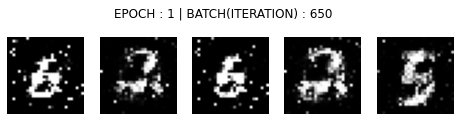

[Epoch: 1/250] [Batch: 657/657] [D loss: 0.067594] [G loss: 3.075670]


  0%|          | 0/657 [00:00<?, ?it/s]

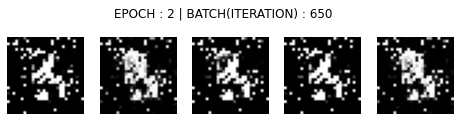

[Epoch: 2/250] [Batch: 657/657] [D loss: 0.243435] [G loss: 3.330739]


  0%|          | 0/657 [00:00<?, ?it/s]

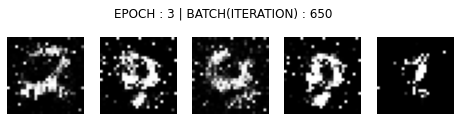

[Epoch: 3/250] [Batch: 657/657] [D loss: 0.081140] [G loss: 4.129048]


  0%|          | 0/657 [00:00<?, ?it/s]

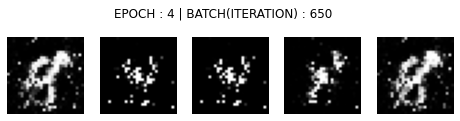

[Epoch: 4/250] [Batch: 657/657] [D loss: 0.348274] [G loss: 0.912885]


  0%|          | 0/657 [00:00<?, ?it/s]

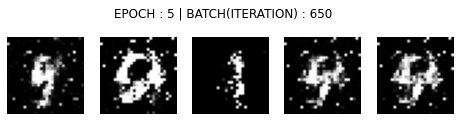

[Epoch: 5/250] [Batch: 657/657] [D loss: 0.044572] [G loss: 3.025795]


  0%|          | 0/657 [00:00<?, ?it/s]

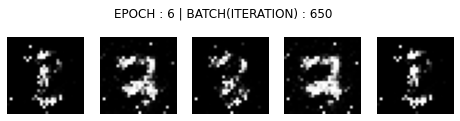

[Epoch: 6/250] [Batch: 657/657] [D loss: 0.266923] [G loss: 2.864268]


  0%|          | 0/657 [00:00<?, ?it/s]

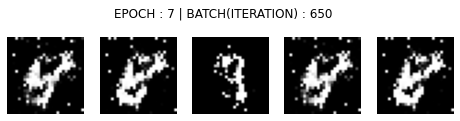

[Epoch: 7/250] [Batch: 657/657] [D loss: 0.152613] [G loss: 4.717355]


  0%|          | 0/657 [00:00<?, ?it/s]

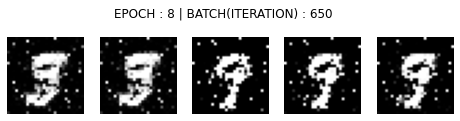

[Epoch: 8/250] [Batch: 657/657] [D loss: 0.195894] [G loss: 1.904922]


  0%|          | 0/657 [00:00<?, ?it/s]

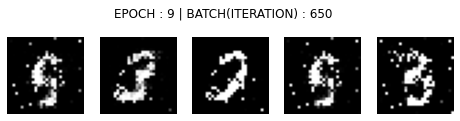

[Epoch: 9/250] [Batch: 657/657] [D loss: 0.024327] [G loss: 4.157307]


  0%|          | 0/657 [00:00<?, ?it/s]

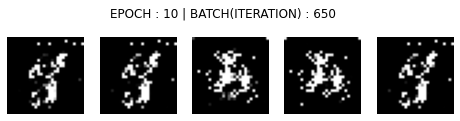

[Epoch: 10/250] [Batch: 657/657] [D loss: 0.109795] [G loss: 2.224349]


  0%|          | 0/657 [00:00<?, ?it/s]

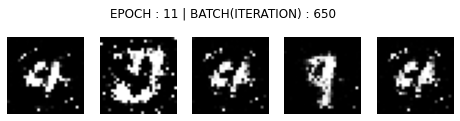

[Epoch: 11/250] [Batch: 657/657] [D loss: 0.779718] [G loss: 0.530019]


  0%|          | 0/657 [00:00<?, ?it/s]

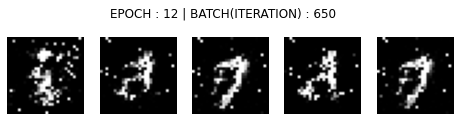

[Epoch: 12/250] [Batch: 657/657] [D loss: 0.069771] [G loss: 2.585062]


  0%|          | 0/657 [00:00<?, ?it/s]

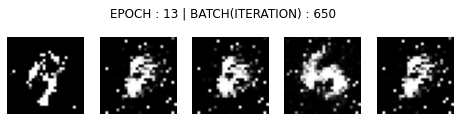

[Epoch: 13/250] [Batch: 657/657] [D loss: 0.074258] [G loss: 3.578318]


  0%|          | 0/657 [00:00<?, ?it/s]

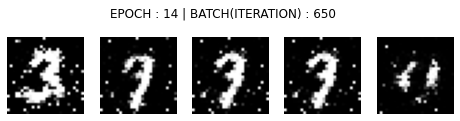

[Epoch: 14/250] [Batch: 657/657] [D loss: 0.089245] [G loss: 3.408707]


  0%|          | 0/657 [00:00<?, ?it/s]

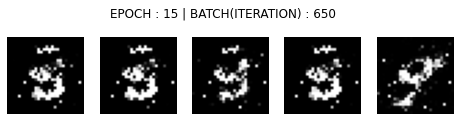

[Epoch: 15/250] [Batch: 657/657] [D loss: 0.048970] [G loss: 3.901563]


  0%|          | 0/657 [00:00<?, ?it/s]

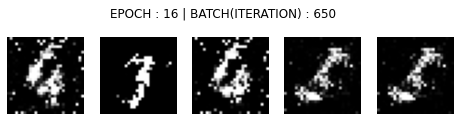

[Epoch: 16/250] [Batch: 657/657] [D loss: 0.397750] [G loss: 5.050499]


  0%|          | 0/657 [00:00<?, ?it/s]

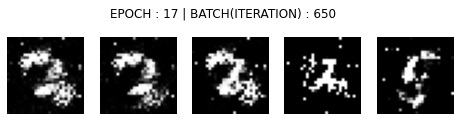

[Epoch: 17/250] [Batch: 657/657] [D loss: 0.679342] [G loss: 4.751075]


  0%|          | 0/657 [00:00<?, ?it/s]

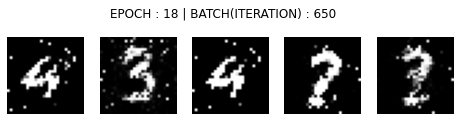

[Epoch: 18/250] [Batch: 657/657] [D loss: 0.270302] [G loss: 6.209736]


  0%|          | 0/657 [00:00<?, ?it/s]

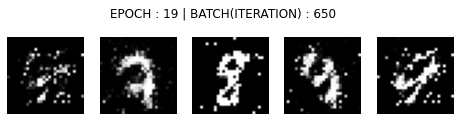

[Epoch: 19/250] [Batch: 657/657] [D loss: 0.123005] [G loss: 2.223647]


  0%|          | 0/657 [00:00<?, ?it/s]

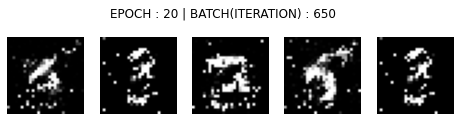

[Epoch: 20/250] [Batch: 657/657] [D loss: 0.102414] [G loss: 2.291203]


  0%|          | 0/657 [00:00<?, ?it/s]

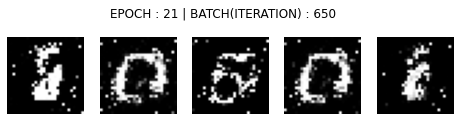

[Epoch: 21/250] [Batch: 657/657] [D loss: 0.090132] [G loss: 2.625526]


  0%|          | 0/657 [00:00<?, ?it/s]

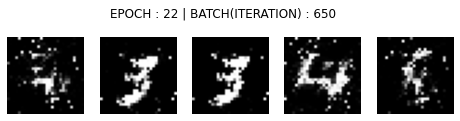

[Epoch: 22/250] [Batch: 657/657] [D loss: 0.030236] [G loss: 3.422817]


  0%|          | 0/657 [00:00<?, ?it/s]

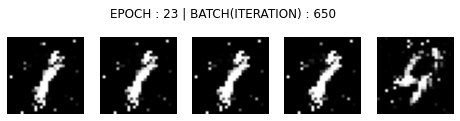

[Epoch: 23/250] [Batch: 657/657] [D loss: 0.296638] [G loss: 3.379926]


  0%|          | 0/657 [00:00<?, ?it/s]

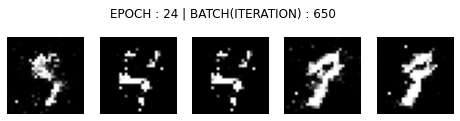

[Epoch: 24/250] [Batch: 657/657] [D loss: 0.097077] [G loss: 2.214160]


  0%|          | 0/657 [00:00<?, ?it/s]

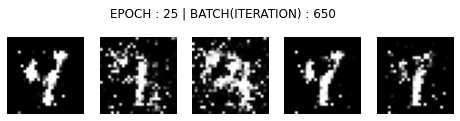

[Epoch: 25/250] [Batch: 657/657] [D loss: 0.185005] [G loss: 3.510911]


  0%|          | 0/657 [00:00<?, ?it/s]

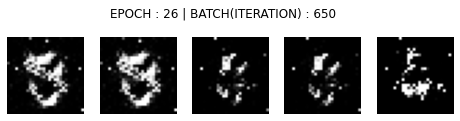

[Epoch: 26/250] [Batch: 657/657] [D loss: 0.135713] [G loss: 2.158630]


  0%|          | 0/657 [00:00<?, ?it/s]

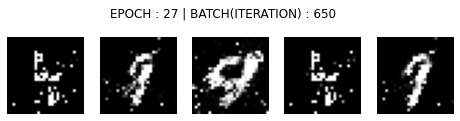

[Epoch: 27/250] [Batch: 657/657] [D loss: 0.157196] [G loss: 2.377984]


  0%|          | 0/657 [00:00<?, ?it/s]

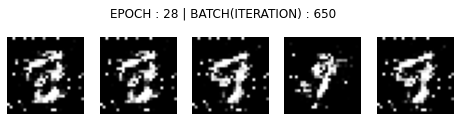

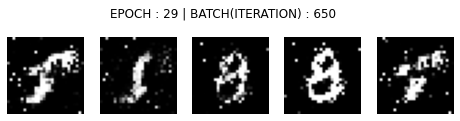

[Epoch: 29/250] [Batch: 657/657] [D loss: 0.254101] [G loss: 5.310236]


  0%|          | 0/657 [00:00<?, ?it/s]

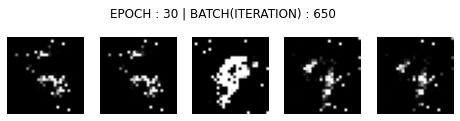

[Epoch: 30/250] [Batch: 657/657] [D loss: 0.094969] [G loss: 2.355649]


  0%|          | 0/657 [00:00<?, ?it/s]

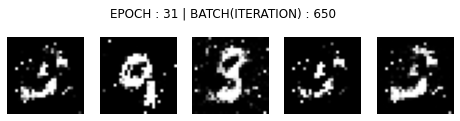

[Epoch: 31/250] [Batch: 657/657] [D loss: 0.098002] [G loss: 2.644043]


  0%|          | 0/657 [00:00<?, ?it/s]

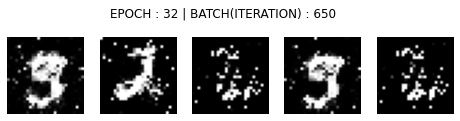

[Epoch: 32/250] [Batch: 657/657] [D loss: 0.035187] [G loss: 4.151319]


  0%|          | 0/657 [00:00<?, ?it/s]

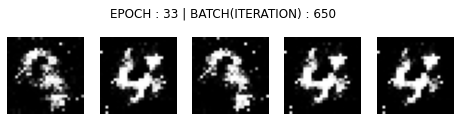

[Epoch: 33/250] [Batch: 657/657] [D loss: 0.125454] [G loss: 4.395218]


  0%|          | 0/657 [00:00<?, ?it/s]

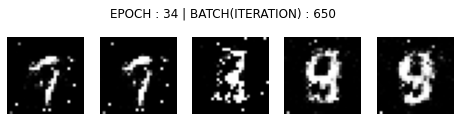

[Epoch: 34/250] [Batch: 657/657] [D loss: 0.201182] [G loss: 2.889103]


  0%|          | 0/657 [00:00<?, ?it/s]

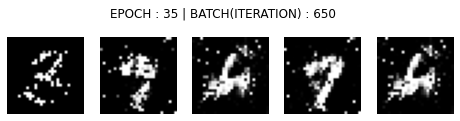

[Epoch: 35/250] [Batch: 657/657] [D loss: 0.300749] [G loss: 2.083911]


  0%|          | 0/657 [00:00<?, ?it/s]

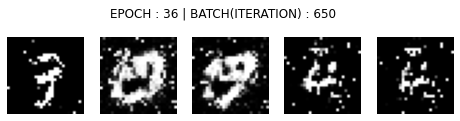

[Epoch: 36/250] [Batch: 657/657] [D loss: 0.008677] [G loss: 4.729717]


  0%|          | 0/657 [00:00<?, ?it/s]

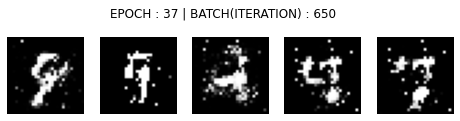

[Epoch: 37/250] [Batch: 657/657] [D loss: 0.092976] [G loss: 3.093389]


  0%|          | 0/657 [00:00<?, ?it/s]

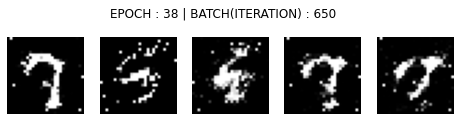

[Epoch: 38/250] [Batch: 657/657] [D loss: 0.065373] [G loss: 4.309403]


  0%|          | 0/657 [00:00<?, ?it/s]

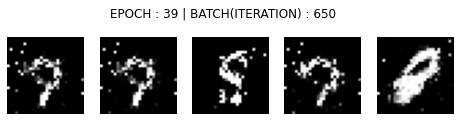

[Epoch: 39/250] [Batch: 657/657] [D loss: 0.255277] [G loss: 2.441030]


  0%|          | 0/657 [00:00<?, ?it/s]

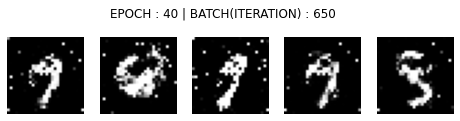

[Epoch: 40/250] [Batch: 657/657] [D loss: 0.080395] [G loss: 3.581773]


  0%|          | 0/657 [00:00<?, ?it/s]

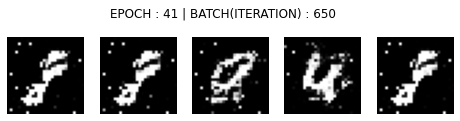

[Epoch: 41/250] [Batch: 657/657] [D loss: 0.119905] [G loss: 4.346529]


  0%|          | 0/657 [00:00<?, ?it/s]

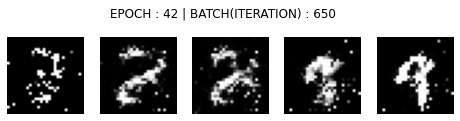

[Epoch: 42/250] [Batch: 657/657] [D loss: 0.040329] [G loss: 4.711060]


  0%|          | 0/657 [00:00<?, ?it/s]

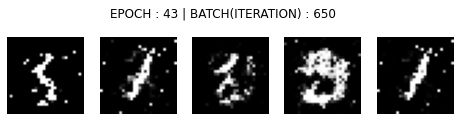

[Epoch: 43/250] [Batch: 657/657] [D loss: 0.203945] [G loss: 5.240108]


  0%|          | 0/657 [00:00<?, ?it/s]

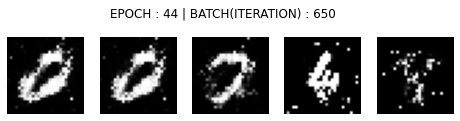

[Epoch: 44/250] [Batch: 657/657] [D loss: 0.129237] [G loss: 2.958140]


  0%|          | 0/657 [00:00<?, ?it/s]

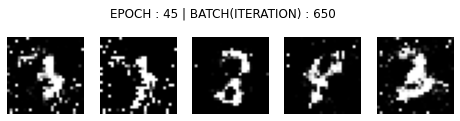

[Epoch: 45/250] [Batch: 657/657] [D loss: 0.056124] [G loss: 3.595149]


  0%|          | 0/657 [00:00<?, ?it/s]

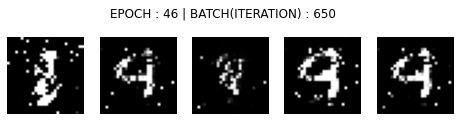

[Epoch: 46/250] [Batch: 657/657] [D loss: 0.564710] [G loss: 8.706879]


  0%|          | 0/657 [00:00<?, ?it/s]

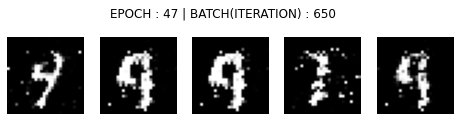

[Epoch: 47/250] [Batch: 657/657] [D loss: 0.207298] [G loss: 2.945687]


  0%|          | 0/657 [00:00<?, ?it/s]

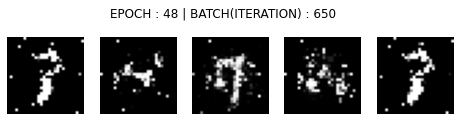

[Epoch: 48/250] [Batch: 657/657] [D loss: 0.181181] [G loss: 1.776583]


  0%|          | 0/657 [00:00<?, ?it/s]

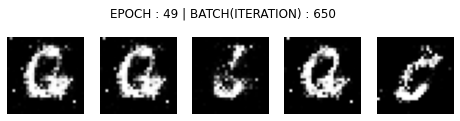

[Epoch: 49/250] [Batch: 657/657] [D loss: 0.118346] [G loss: 3.322061]


  0%|          | 0/657 [00:00<?, ?it/s]

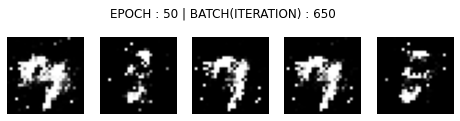

[Epoch: 50/250] [Batch: 657/657] [D loss: 0.069099] [G loss: 2.990502]


  0%|          | 0/657 [00:00<?, ?it/s]

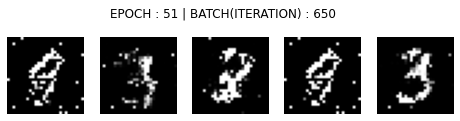

[Epoch: 51/250] [Batch: 657/657] [D loss: 0.052595] [G loss: 3.242967]


  0%|          | 0/657 [00:00<?, ?it/s]

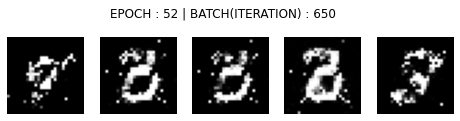

[Epoch: 52/250] [Batch: 657/657] [D loss: 0.294743] [G loss: 4.732226]


  0%|          | 0/657 [00:00<?, ?it/s]

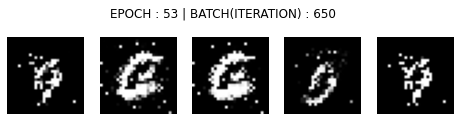

[Epoch: 53/250] [Batch: 657/657] [D loss: 0.230321] [G loss: 4.006210]


  0%|          | 0/657 [00:00<?, ?it/s]

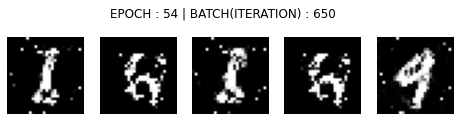

[Epoch: 54/250] [Batch: 657/657] [D loss: 0.048021] [G loss: 3.280028]


  0%|          | 0/657 [00:00<?, ?it/s]

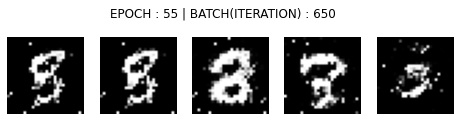

[Epoch: 55/250] [Batch: 657/657] [D loss: 0.143101] [G loss: 3.967546]


  0%|          | 0/657 [00:00<?, ?it/s]

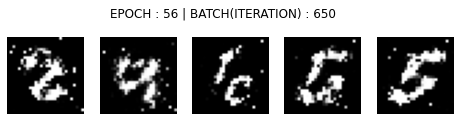

[Epoch: 56/250] [Batch: 657/657] [D loss: 0.193306] [G loss: 1.445117]


  0%|          | 0/657 [00:00<?, ?it/s]

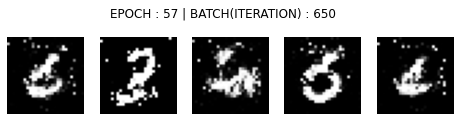

[Epoch: 57/250] [Batch: 657/657] [D loss: 0.204671] [G loss: 1.893560]


  0%|          | 0/657 [00:00<?, ?it/s]

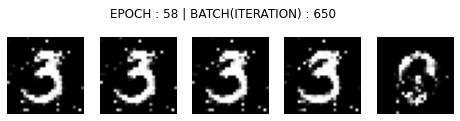

[Epoch: 58/250] [Batch: 657/657] [D loss: 0.113242] [G loss: 3.731014]


  0%|          | 0/657 [00:00<?, ?it/s]

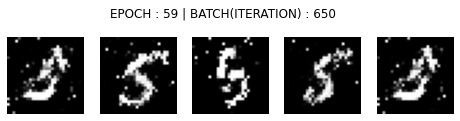

[Epoch: 59/250] [Batch: 657/657] [D loss: 0.030097] [G loss: 3.550438]


  0%|          | 0/657 [00:00<?, ?it/s]

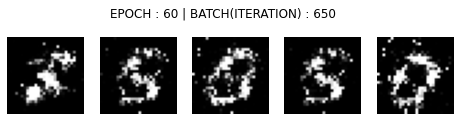

[Epoch: 60/250] [Batch: 657/657] [D loss: 0.338140] [G loss: 2.396499]


  0%|          | 0/657 [00:00<?, ?it/s]

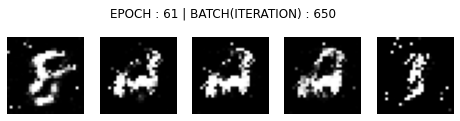

[Epoch: 61/250] [Batch: 657/657] [D loss: 0.155103] [G loss: 2.099809]


  0%|          | 0/657 [00:00<?, ?it/s]

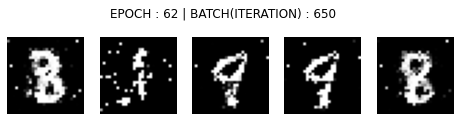

[Epoch: 62/250] [Batch: 657/657] [D loss: 0.182228] [G loss: 3.039413]


  0%|          | 0/657 [00:00<?, ?it/s]

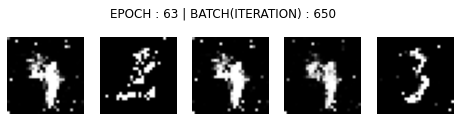

[Epoch: 63/250] [Batch: 657/657] [D loss: 0.062448] [G loss: 3.113086]


  0%|          | 0/657 [00:00<?, ?it/s]

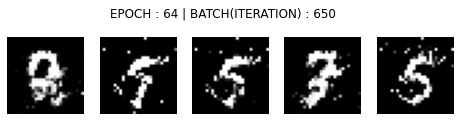

[Epoch: 64/250] [Batch: 657/657] [D loss: 0.338500] [G loss: 2.909618]


  0%|          | 0/657 [00:00<?, ?it/s]

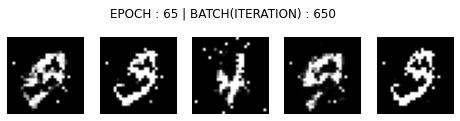

[Epoch: 65/250] [Batch: 657/657] [D loss: 0.185943] [G loss: 2.463809]


  0%|          | 0/657 [00:00<?, ?it/s]

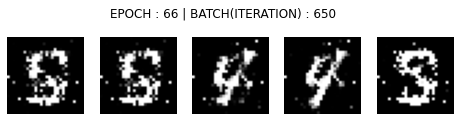

[Epoch: 66/250] [Batch: 657/657] [D loss: 0.070176] [G loss: 3.050959]


  0%|          | 0/657 [00:00<?, ?it/s]

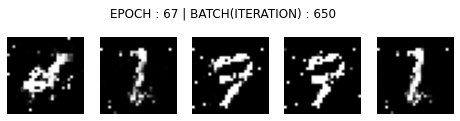

[Epoch: 67/250] [Batch: 657/657] [D loss: 0.428249] [G loss: 0.818551]


  0%|          | 0/657 [00:00<?, ?it/s]

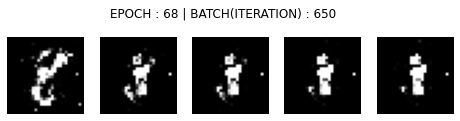

[Epoch: 68/250] [Batch: 657/657] [D loss: 0.176180] [G loss: 2.378993]


  0%|          | 0/657 [00:00<?, ?it/s]

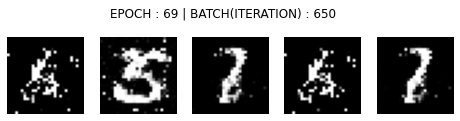

[Epoch: 69/250] [Batch: 657/657] [D loss: 0.425905] [G loss: 8.555552]


  0%|          | 0/657 [00:00<?, ?it/s]

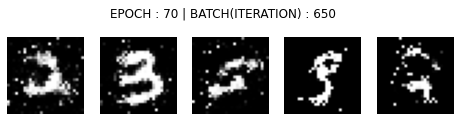

[Epoch: 70/250] [Batch: 657/657] [D loss: 0.035953] [G loss: 3.831015]


  0%|          | 0/657 [00:00<?, ?it/s]

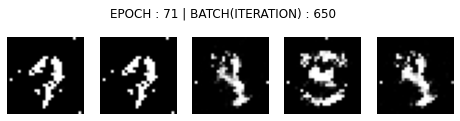

[Epoch: 71/250] [Batch: 657/657] [D loss: 0.106364] [G loss: 2.059370]


  0%|          | 0/657 [00:00<?, ?it/s]

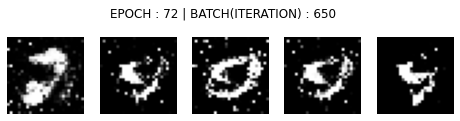

[Epoch: 72/250] [Batch: 657/657] [D loss: 0.120333] [G loss: 4.501870]


  0%|          | 0/657 [00:00<?, ?it/s]

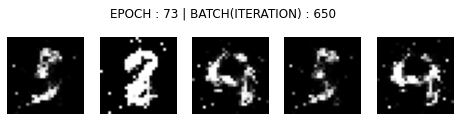

[Epoch: 73/250] [Batch: 657/657] [D loss: 0.084664] [G loss: 3.494103]


  0%|          | 0/657 [00:00<?, ?it/s]

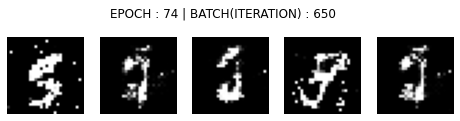

[Epoch: 74/250] [Batch: 657/657] [D loss: 0.189306] [G loss: 6.448537]


  0%|          | 0/657 [00:00<?, ?it/s]

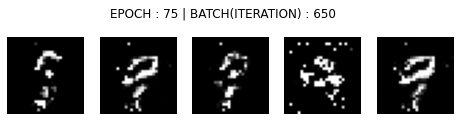

[Epoch: 75/250] [Batch: 657/657] [D loss: 0.190548] [G loss: 2.504859]


  0%|          | 0/657 [00:00<?, ?it/s]

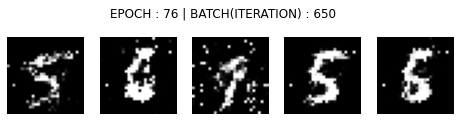

[Epoch: 76/250] [Batch: 657/657] [D loss: 0.117758] [G loss: 2.372874]


  0%|          | 0/657 [00:00<?, ?it/s]

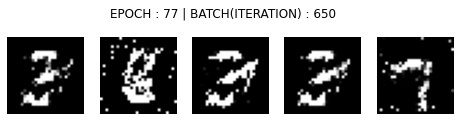

[Epoch: 77/250] [Batch: 657/657] [D loss: 0.217989] [G loss: 3.516535]


  0%|          | 0/657 [00:00<?, ?it/s]

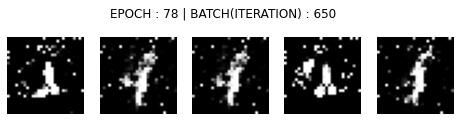

[Epoch: 78/250] [Batch: 657/657] [D loss: 0.132748] [G loss: 3.263958]


  0%|          | 0/657 [00:00<?, ?it/s]

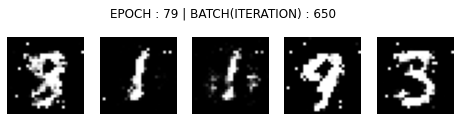

[Epoch: 79/250] [Batch: 657/657] [D loss: 0.098484] [G loss: 3.068949]


  0%|          | 0/657 [00:00<?, ?it/s]

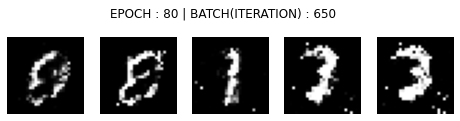

[Epoch: 80/250] [Batch: 657/657] [D loss: 0.094138] [G loss: 3.056435]


  0%|          | 0/657 [00:00<?, ?it/s]

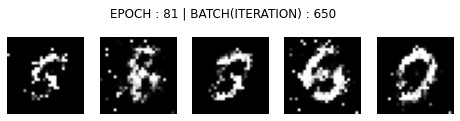

[Epoch: 81/250] [Batch: 657/657] [D loss: 0.079193] [G loss: 3.680619]


  0%|          | 0/657 [00:00<?, ?it/s]

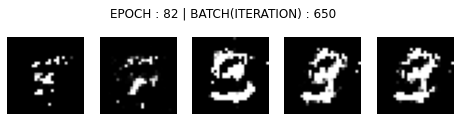

[Epoch: 82/250] [Batch: 657/657] [D loss: 0.025863] [G loss: 3.665540]


  0%|          | 0/657 [00:00<?, ?it/s]

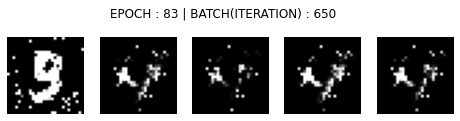

[Epoch: 83/250] [Batch: 657/657] [D loss: 0.132053] [G loss: 2.853916]


  0%|          | 0/657 [00:00<?, ?it/s]

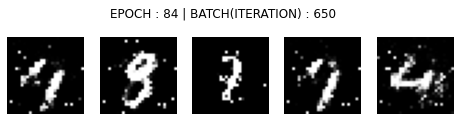

[Epoch: 84/250] [Batch: 657/657] [D loss: 0.055723] [G loss: 2.589942]


  0%|          | 0/657 [00:00<?, ?it/s]

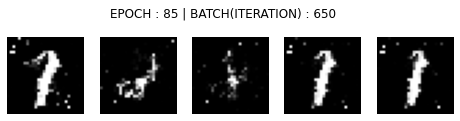

[Epoch: 85/250] [Batch: 657/657] [D loss: 0.404791] [G loss: 3.943833]


  0%|          | 0/657 [00:00<?, ?it/s]

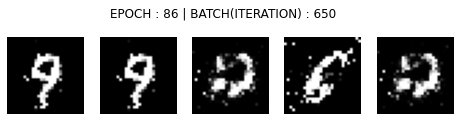

[Epoch: 86/250] [Batch: 657/657] [D loss: 0.086808] [G loss: 2.595247]


  0%|          | 0/657 [00:00<?, ?it/s]

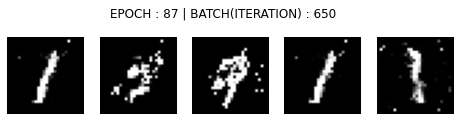

[Epoch: 87/250] [Batch: 657/657] [D loss: 0.156045] [G loss: 2.431984]


  0%|          | 0/657 [00:00<?, ?it/s]

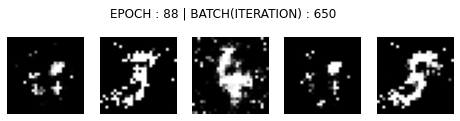

[Epoch: 88/250] [Batch: 657/657] [D loss: 0.162179] [G loss: 2.411942]


  0%|          | 0/657 [00:00<?, ?it/s]

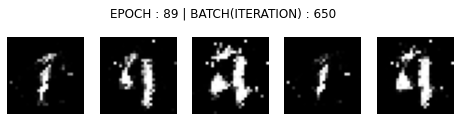

[Epoch: 89/250] [Batch: 657/657] [D loss: 0.273834] [G loss: 3.399894]


  0%|          | 0/657 [00:00<?, ?it/s]

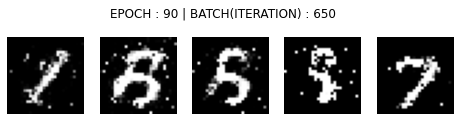

[Epoch: 90/250] [Batch: 657/657] [D loss: 0.512581] [G loss: 6.392773]


  0%|          | 0/657 [00:00<?, ?it/s]

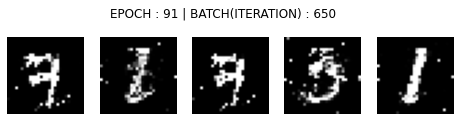

[Epoch: 91/250] [Batch: 657/657] [D loss: 0.424169] [G loss: 4.709007]


  0%|          | 0/657 [00:00<?, ?it/s]

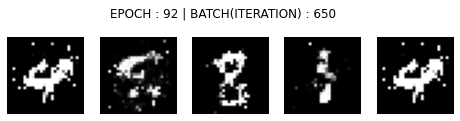

[Epoch: 92/250] [Batch: 657/657] [D loss: 0.045211] [G loss: 2.986399]


  0%|          | 0/657 [00:00<?, ?it/s]

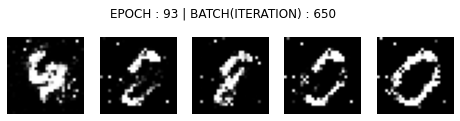

[Epoch: 93/250] [Batch: 657/657] [D loss: 0.147995] [G loss: 3.705431]


  0%|          | 0/657 [00:00<?, ?it/s]

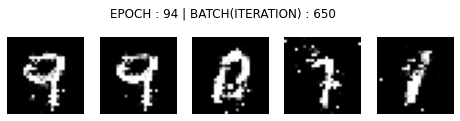

[Epoch: 94/250] [Batch: 657/657] [D loss: 0.032005] [G loss: 4.114057]


  0%|          | 0/657 [00:00<?, ?it/s]

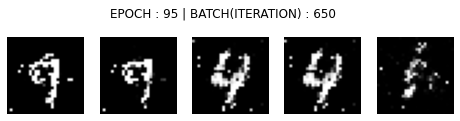

[Epoch: 95/250] [Batch: 657/657] [D loss: 0.117937] [G loss: 5.203274]


  0%|          | 0/657 [00:00<?, ?it/s]

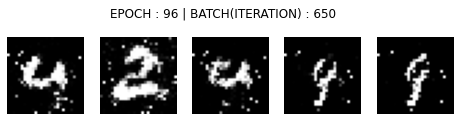

[Epoch: 96/250] [Batch: 657/657] [D loss: 0.116495] [G loss: 2.855605]


  0%|          | 0/657 [00:00<?, ?it/s]

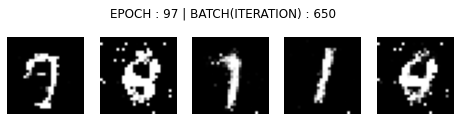

[Epoch: 97/250] [Batch: 657/657] [D loss: 0.112243] [G loss: 2.727512]


  0%|          | 0/657 [00:00<?, ?it/s]

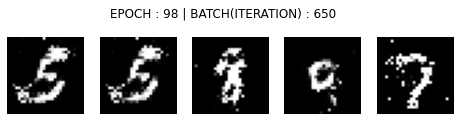

[Epoch: 98/250] [Batch: 657/657] [D loss: 0.107229] [G loss: 4.782939]


  0%|          | 0/657 [00:00<?, ?it/s]

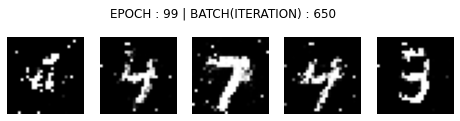

[Epoch: 99/250] [Batch: 657/657] [D loss: 0.156430] [G loss: 2.665712]


  0%|          | 0/657 [00:00<?, ?it/s]

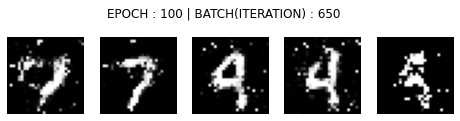

[Epoch: 100/250] [Batch: 657/657] [D loss: 0.220741] [G loss: 2.342399]


  0%|          | 0/657 [00:00<?, ?it/s]

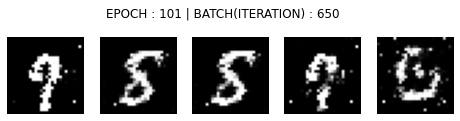

[Epoch: 101/250] [Batch: 657/657] [D loss: 0.293379] [G loss: 5.170974]


  0%|          | 0/657 [00:00<?, ?it/s]

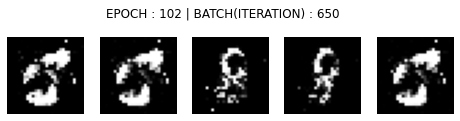

[Epoch: 102/250] [Batch: 657/657] [D loss: 0.081589] [G loss: 2.296031]


  0%|          | 0/657 [00:00<?, ?it/s]

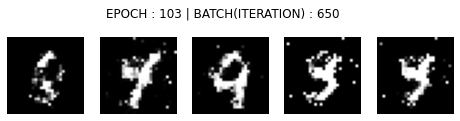

[Epoch: 103/250] [Batch: 657/657] [D loss: 0.273401] [G loss: 3.323267]


  0%|          | 0/657 [00:00<?, ?it/s]

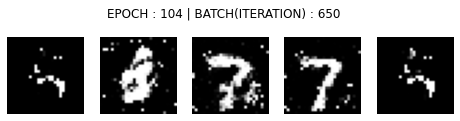

[Epoch: 104/250] [Batch: 657/657] [D loss: 0.093797] [G loss: 3.427708]


  0%|          | 0/657 [00:00<?, ?it/s]

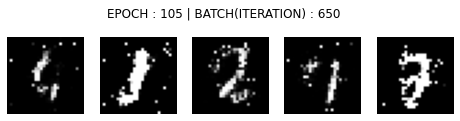

[Epoch: 105/250] [Batch: 657/657] [D loss: 0.382556] [G loss: 3.157206]


  0%|          | 0/657 [00:00<?, ?it/s]

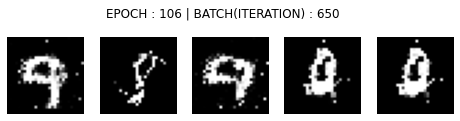

[Epoch: 106/250] [Batch: 657/657] [D loss: 0.052244] [G loss: 3.973432]


  0%|          | 0/657 [00:00<?, ?it/s]

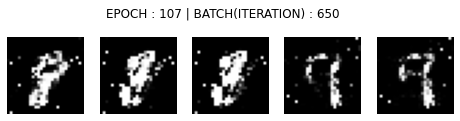

[Epoch: 107/250] [Batch: 657/657] [D loss: 0.111902] [G loss: 2.197428]


  0%|          | 0/657 [00:00<?, ?it/s]

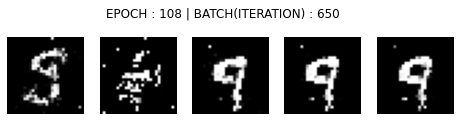

[Epoch: 108/250] [Batch: 657/657] [D loss: 0.054668] [G loss: 3.628517]


  0%|          | 0/657 [00:00<?, ?it/s]

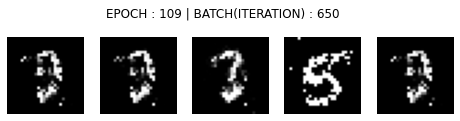

[Epoch: 109/250] [Batch: 657/657] [D loss: 0.082105] [G loss: 2.517334]


  0%|          | 0/657 [00:00<?, ?it/s]

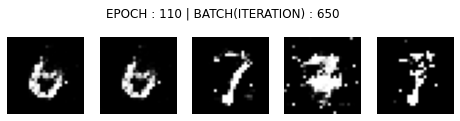

[Epoch: 110/250] [Batch: 657/657] [D loss: 0.149955] [G loss: 3.576508]


  0%|          | 0/657 [00:00<?, ?it/s]

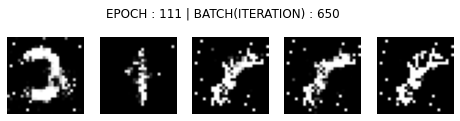

[Epoch: 111/250] [Batch: 657/657] [D loss: 0.165728] [G loss: 1.784986]


  0%|          | 0/657 [00:00<?, ?it/s]

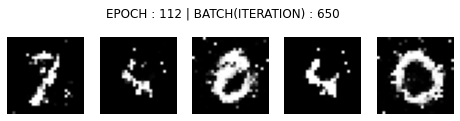

[Epoch: 112/250] [Batch: 657/657] [D loss: 0.062533] [G loss: 2.543038]


  0%|          | 0/657 [00:00<?, ?it/s]

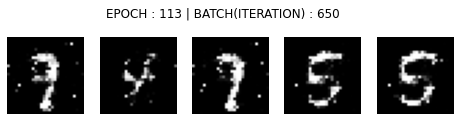

[Epoch: 113/250] [Batch: 657/657] [D loss: 0.176336] [G loss: 1.549919]


  0%|          | 0/657 [00:00<?, ?it/s]

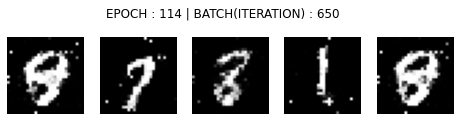

[Epoch: 114/250] [Batch: 657/657] [D loss: 0.098024] [G loss: 2.354641]


  0%|          | 0/657 [00:00<?, ?it/s]

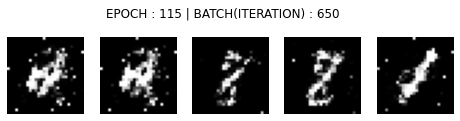

[Epoch: 115/250] [Batch: 657/657] [D loss: 0.257101] [G loss: 3.000272]


  0%|          | 0/657 [00:00<?, ?it/s]

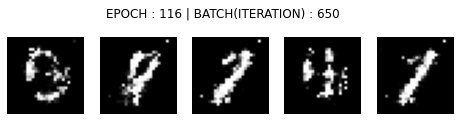

[Epoch: 116/250] [Batch: 657/657] [D loss: 0.059934] [G loss: 3.830370]


  0%|          | 0/657 [00:00<?, ?it/s]

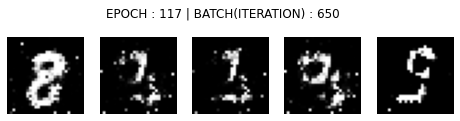

[Epoch: 117/250] [Batch: 657/657] [D loss: 0.052115] [G loss: 2.983893]


  0%|          | 0/657 [00:00<?, ?it/s]

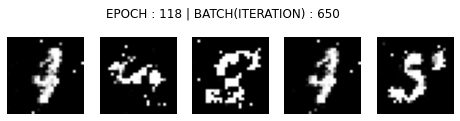

[Epoch: 118/250] [Batch: 657/657] [D loss: 0.140336] [G loss: 6.356395]


  0%|          | 0/657 [00:00<?, ?it/s]

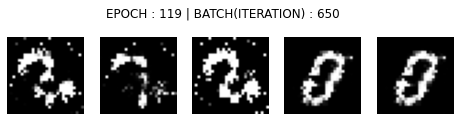

[Epoch: 119/250] [Batch: 657/657] [D loss: 0.360428] [G loss: 2.704957]


  0%|          | 0/657 [00:00<?, ?it/s]

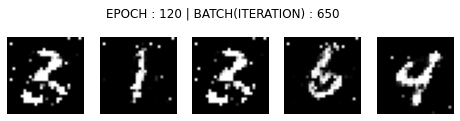

[Epoch: 120/250] [Batch: 657/657] [D loss: 0.045382] [G loss: 4.663452]


  0%|          | 0/657 [00:00<?, ?it/s]

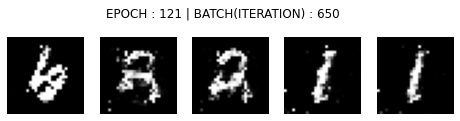

[Epoch: 121/250] [Batch: 657/657] [D loss: 0.359239] [G loss: 2.611889]


  0%|          | 0/657 [00:00<?, ?it/s]

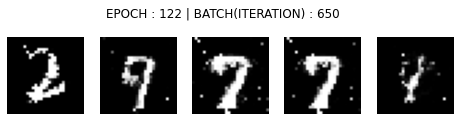

[Epoch: 122/250] [Batch: 657/657] [D loss: 0.095452] [G loss: 3.731581]


  0%|          | 0/657 [00:00<?, ?it/s]

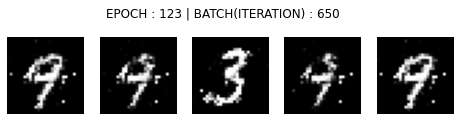

[Epoch: 123/250] [Batch: 657/657] [D loss: 0.313466] [G loss: 2.155937]


  0%|          | 0/657 [00:00<?, ?it/s]

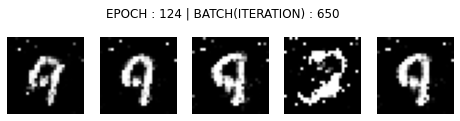

[Epoch: 124/250] [Batch: 657/657] [D loss: 0.186799] [G loss: 3.328362]


  0%|          | 0/657 [00:00<?, ?it/s]

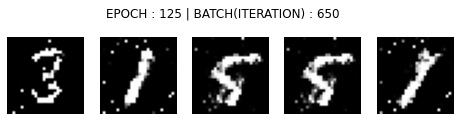

[Epoch: 125/250] [Batch: 657/657] [D loss: 0.197026] [G loss: 2.305759]


  0%|          | 0/657 [00:00<?, ?it/s]

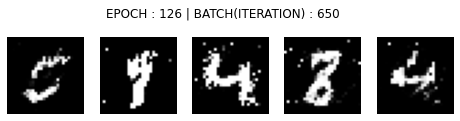

[Epoch: 126/250] [Batch: 657/657] [D loss: 0.203724] [G loss: 3.162683]


  0%|          | 0/657 [00:00<?, ?it/s]

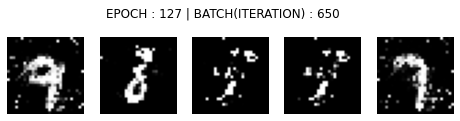

[Epoch: 127/250] [Batch: 657/657] [D loss: 0.238060] [G loss: 2.163112]


  0%|          | 0/657 [00:00<?, ?it/s]

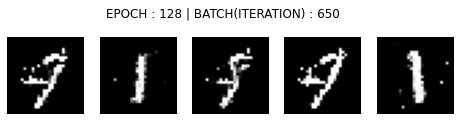

[Epoch: 128/250] [Batch: 657/657] [D loss: 0.087197] [G loss: 3.433332]


  0%|          | 0/657 [00:00<?, ?it/s]

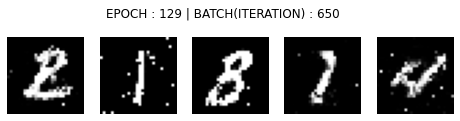

[Epoch: 129/250] [Batch: 657/657] [D loss: 0.101925] [G loss: 4.365808]


  0%|          | 0/657 [00:00<?, ?it/s]

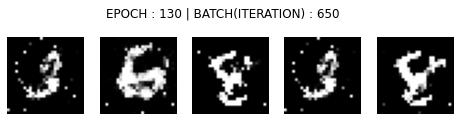

[Epoch: 130/250] [Batch: 657/657] [D loss: 0.126183] [G loss: 4.083407]


  0%|          | 0/657 [00:00<?, ?it/s]

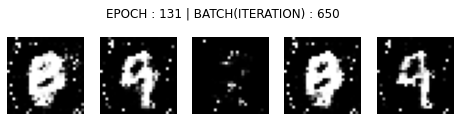

[Epoch: 131/250] [Batch: 657/657] [D loss: 0.067081] [G loss: 3.221870]


  0%|          | 0/657 [00:00<?, ?it/s]

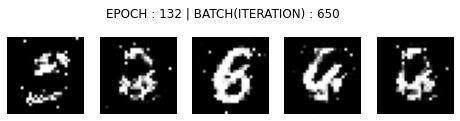

[Epoch: 132/250] [Batch: 657/657] [D loss: 0.189474] [G loss: 4.191529]


  0%|          | 0/657 [00:00<?, ?it/s]

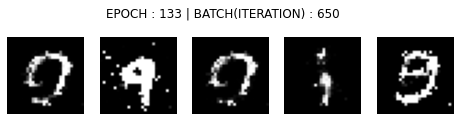

[Epoch: 133/250] [Batch: 657/657] [D loss: 0.064797] [G loss: 3.459185]


  0%|          | 0/657 [00:00<?, ?it/s]

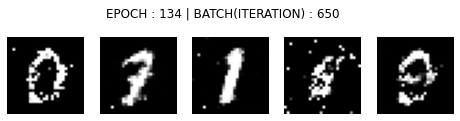

[Epoch: 134/250] [Batch: 657/657] [D loss: 0.375258] [G loss: 3.101569]


  0%|          | 0/657 [00:00<?, ?it/s]

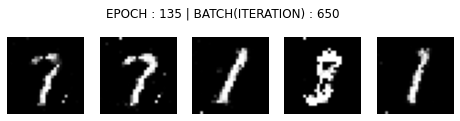

[Epoch: 135/250] [Batch: 657/657] [D loss: 0.029364] [G loss: 4.523892]


  0%|          | 0/657 [00:00<?, ?it/s]

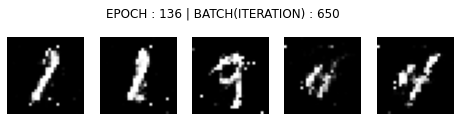

[Epoch: 136/250] [Batch: 657/657] [D loss: 0.273273] [G loss: 3.304771]


  0%|          | 0/657 [00:00<?, ?it/s]

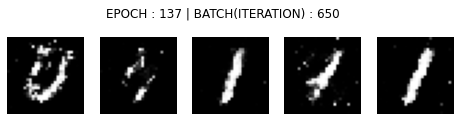

[Epoch: 137/250] [Batch: 657/657] [D loss: 0.080791] [G loss: 3.225739]


  0%|          | 0/657 [00:00<?, ?it/s]

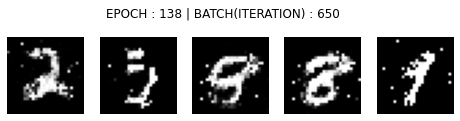

[Epoch: 138/250] [Batch: 657/657] [D loss: 0.085903] [G loss: 2.780196]


  0%|          | 0/657 [00:00<?, ?it/s]

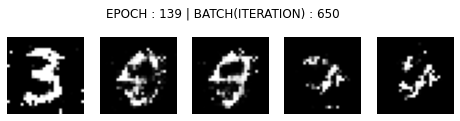

[Epoch: 139/250] [Batch: 657/657] [D loss: 0.134345] [G loss: 2.675801]


  0%|          | 0/657 [00:00<?, ?it/s]

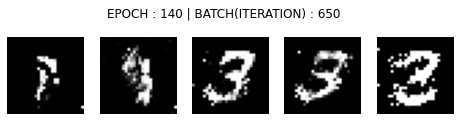

[Epoch: 140/250] [Batch: 657/657] [D loss: 0.444819] [G loss: 3.765572]


  0%|          | 0/657 [00:00<?, ?it/s]

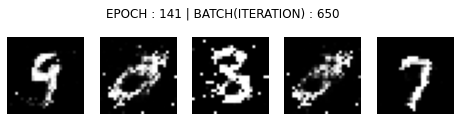

[Epoch: 141/250] [Batch: 657/657] [D loss: 0.098531] [G loss: 5.212769]


  0%|          | 0/657 [00:00<?, ?it/s]

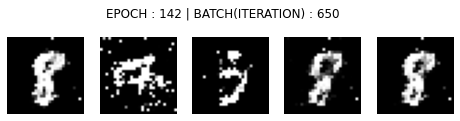

[Epoch: 142/250] [Batch: 657/657] [D loss: 0.040123] [G loss: 4.145463]


  0%|          | 0/657 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [53]:
n_epochs = 250 # suggested default = 200
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(tqdm(dataloader)): # This code(enumerate) is dealt with once more in the *TEST_CODE below.
                                                     # Used 'tqdm' for showing progress 
        
        # Adversarial ground truths (For more detail, refer *Read_More below)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) # imgs.size(0) == batch_size(1 batch) == 64, *TEST_CODE
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) # And Variable is for caclulate gradient. In fact, you can use it, but you don't have to. 
                                                                                # requires_grad=False is default in tensor type. *Read_More
        
        # Configure input
        real_imgs = imgs.type(Tensor) # As mentioned, it is no longer necessary to wrap the tensor in a Variable.
      # real_imgs = Variable(imgs.type(Tensor)) # requires_grad=False, Default! It's same.
    
# ------------
# Train Generator
# ------------
        optimizer_G.zero_grad()
        
        # sample noise 'z' as generator input
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim))) # Random sampling Tensor(batch_size, latent_dim) of Gaussian distribution
        # z.shape == torch.Size([64, 100])
        
        # Generate a batch of images
        gen_imgs = generator(z)
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])
        
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
        
        g_loss.backward()
        optimizer_G.step()
        
# ------------
# Train Discriminator
# ------------
        optimizer_D.zero_grad()
        
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake) # We are learning the discriminator now. So have to use detach() 
                                                                             
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()# If didn't use detach() for gen_imgs, all weights of the generator will be calculated with backward(). 
        optimizer_D.step()
         
    

# ------------
# Real Time Visualization (While Training)
# ------------
        
        sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
        # z.shape == torch.Size([64, 100])
        sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])
        
        if ((i+1) % 650) == 0: # show while batch - 200/657, 400/657, 600/657
            nrow=1
            ncols=5
            fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
            plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
            for ncol in range(ncols):
                axes[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
                axes[ncol].axis('off')
            plt.show()
    print(
        "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, n_epochs, i+1, len(dataloader), d_loss.item(), g_loss.item())
    )

> TEST CODE : enumerate >> [docs.python.org/enumerate](https://docs.python.org/3/library/functions.html#enumerate)

In [29]:
# result of enumerate
count = 1
for i, (imgs,label) in enumerate(dataloader):
    print('Shape of Batch Images : \n', imgs.shape)
    print('Labels (1~64) : \n', label)
    print('-'*100)
    if count == 5:
        break
    else:
        count += 1

Shape of Batch Images : 
 torch.Size([64, 1, 28, 28])
Labels (1~64) : 
 tensor([1, 1, 2, 8, 3, 5, 3, 0, 6, 4, 7, 7, 4, 9, 2, 7, 3, 4, 8, 7, 4, 4, 4, 3,
        9, 1, 1, 3, 3, 7, 1, 0, 0, 6, 8, 7, 4, 8, 4, 4, 1, 5, 1, 8, 2, 9, 3, 2,
        4, 6, 5, 9, 9, 0, 0, 3, 9, 9, 3, 1, 2, 7, 5, 5])
----------------------------------------------------------------------------------------------------
Shape of Batch Images : 
 torch.Size([64, 1, 28, 28])
Labels (1~64) : 
 tensor([4, 7, 2, 7, 7, 8, 9, 6, 6, 8, 9, 9, 2, 5, 1, 5, 0, 8, 2, 2, 9, 6, 4, 9,
        7, 3, 4, 0, 0, 6, 3, 3, 5, 4, 3, 0, 0, 9, 9, 7, 7, 1, 0, 0, 6, 8, 3, 1,
        7, 8, 0, 5, 3, 6, 3, 7, 5, 0, 5, 3, 5, 0, 3, 3])
----------------------------------------------------------------------------------------------------
Shape of Batch Images : 
 torch.Size([64, 1, 28, 28])
Labels (1~64) : 
 tensor([8, 0, 2, 7, 7, 2, 7, 5, 4, 0, 2, 4, 9, 0, 7, 0, 8, 6, 3, 4, 5, 8, 5, 0,
        7, 2, 0, 3, 9, 3, 1, 7, 1, 4, 2, 0, 2, 9, 4, 1, 1, 5, 8, 9, 

> TEST CODE : 
- Read CSV file
- Tensor(imgs.size(0),1)
- Tensor(imgs.size(0),1).fill_(1.0)

In [30]:
Tensor(10,1) # Just 10 for a quick look. 
             # We dealt with Tensor(imgs.size(0),1) above. Tensor(64,1) <-- len(H) == batch_size == 64, len(W) == 1

tensor([[0.1244],
        [0.0314],
        [0.0320],
        [0.0315],
        [0.0316],
        [0.0319],
        [0.0319],
        [0.0315],
        [0.0319],
        [0.0316]], device='cuda:0')

In [31]:
Tensor(10,1).fill_(1.0) # _ means inplace, fill the Tensor with 1.0

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')

> TEST CODE : Variable and requires_grad

In [32]:
sample_img = iter(dataloader).next()[0]

In [33]:
sample_img.shape, sample_img.dtype

(torch.Size([64, 1, 28, 28]), torch.float32)

In [34]:
sample_img.requires_grad # default : False 

False

In [35]:
Variable(sample_img).requires_grad # exactly same

False

In [36]:
sample_img.requires_grad_(True) # set requires_grad to True, _ means inplace

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., 

In [37]:
sample_img.requires_grad # Yes. requires_grad changed correctly. you don't need wrapping tensor with Variable. 

True

However, it can be confusing here. Obviously, the derivative is computed through the loss, but not a single `requires_grad` is set to `true`.

Remember, It's different from `model's parameter`. Internally, the parameters of each Module are stored in Tensors with `requires_grad=True` !

> TEST CODE : Ramdom Sampling (H,W) from a normal(Gaussian) distribution 

In [38]:
np.random.normal(0,1,(64,100))

array([[-0.65222498, -0.01576215, -0.10359899, ..., -0.26502711,
        -0.6586733 , -0.02840731],
       [-0.93279134, -0.46254404,  1.15021404, ...,  2.07879778,
         1.27620882,  0.90626983],
       [ 0.70546054, -0.0970536 , -0.03479245, ..., -0.62019034,
        -2.03129476, -1.28431101],
       ...,
       [-1.58204016, -1.3844375 , -1.44944003, ...,  0.40508952,
         0.90417596,  1.10874664],
       [ 0.05053972, -0.14622177, -0.68627856, ..., -0.57217958,
        -0.39550763, -0.61918047],
       [-0.08201972, -0.26264645,  2.11280582, ...,  0.78103121,
         1.78424026, -1.24558725]])

In [39]:
np.random.normal(0,1,(64,100)).shape

(64, 100)

> TEST CODE : shape of z and gen_imgs and discriminator(gen_imgs)

In [40]:
# latent vector
sample_z = Tensor(np.random.normal(0, 1, (64,100)))
sample_z.shape

torch.Size([64, 100])

In [41]:
# generated images
sample_gen_imgs = generator(sample_z)
sample_gen_imgs.shape

torch.Size([64, 1, 28, 28])

In [42]:
# discrimination result
sample_discrim_result = discriminator(sample_gen_imgs)
sample_discrim_result.shape

torch.Size([64, 1])

> TEST CODE : g_loss

In [43]:
adversarial_loss

BCELoss()

In [44]:
sample_valid.shape

NameError: name 'sample_valid' is not defined

In [45]:
sample_valid = Tensor(64,1).fill_(1.0)
sample_g_loss = adversarial_loss(sample_discrim_result, sample_valid)
sample_g_loss

tensor(1.4162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

> TEST CODE : detach()
- refer : [What is PyTorch '.detach()' method? - theroyakash, 2020-11](https://dev.to/theroyakash/what-is-pytorch-detach-method-15oo)

In [46]:
!pip install torchviz
import torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=8c31bbd2bbd983aa5c2b154f55e00a04185788f21116f6f096173006434f9041
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


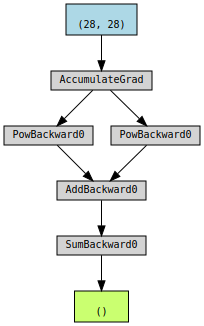

In [47]:
X = torch.ones((28,28), dtype=torch.float32, requires_grad=True)
square_X = X**2
cubic_X = X**3

result = (square_X+cubic_X).sum()

torchviz.make_dot(result)


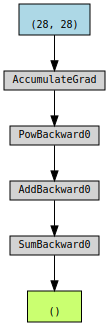

In [48]:
X = torch.ones((28,28), dtype=torch.float32, requires_grad=True)
square_X = X**2
cubic_X = X.detach()**3

result = (square_X+cubic_X).sum()

torchviz.make_dot(result)

> Read More
- [What is Ground Truth? - Definition from Techpedia](https://www.techopedia.com/definition/32514/ground-truth)
- [tqdm. A Fast, Extensible Progress Bar for Python and CLI](https://github.com/tqdm/tqdm)
- [Variables are no longer necessary to use autograd with tensors](https://pytorch.org/docs/stable/autograd.html#variable-deprecated)
- [np.random.normal(loc=0.0, scale=1.0, size=None)](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)



--------------


So far, we have completed the basic model of gan and tested the model through mnist data.

I plan to implement and test more various gan models from the very basics through this series, so let's study together!

Thank you and Enjoy your Kaggle! :)